# Setting up the imports

In [49]:
#@title
# Import Python Modules

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms

# access to data
import io
import os
from os import listdir
from os.path import isfile, join

# data manipulation
import pandas as pd
import numpy as np
from PIL import Image

# scipy images
from scipy.ndimage import rotate
import scipy.stats as st
import scipy

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection

# parallel processing
import multiprocessing
from joblib import delayed, Parallel

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl

# time and random code
import time
import random

# model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

device = "cuda"

In [50]:
#@title

from graphviz import Digraph

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
def visualize(model):
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    # custom script to get all the shapes of a network's layers
    sizes = list()
    state_dict = net.state_dict()
    for idx, key in enumerate(state_dict.keys()):
      if key.endswith('weight'):
        output_size, input_size = state_dict[key].shape
        if idx == 0:
          sizes.append(input_size)
        sizes.append(output_size)

    input_layer = sizes[0]
    for layer in layers:
        if layer == layers[0]:
            hidden_layers.append(layer.out_features)

        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers.append(layer.out_features)

        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename='visualization_tmp')
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
          c.attr(color="white")
          for i in range(0, sizes[0]):
              n += 1
              c.node(str(n))
              c.attr(labeljust="1")
              c.attr(label="Input Layer", labelloc="bottom")
              c.attr(rank="same")
              c.node_attr.update(
                  width="0.65",
                  style="filled",
                  shape="circle",
                  color=HAPPY_COLORS_PALETTE[3],
                  fontcolor=HAPPY_COLORS_PALETTE[3],
              )
    for layer_idx in range(0, len(sizes) - 2):
        with g.subgraph(name="cluster_" + str(layer_idx + 1)) as c:
            c.attr(color="white")
            c.attr(rank="same")
            label = f'Hidden Layer {layer_idx + 1}'
            c.attr(labeljust="right", labelloc="b", label=label)
            for j in range(0, hidden_layers[layer_idx]):
                n += 1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=HAPPY_COLORS_PALETTE[0],
                    fontcolor=HAPPY_COLORS_PALETTE[0],
                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            last_layer_nodes = hidden_layers[layer_idx]
            nodes_up += hidden_layers[layer_idx]

    with g.subgraph(name="cluster_output") as c:
        c.attr(color="white")
        c.attr(rank="same")
        c.attr(labeljust="1")
        for i in range(1, output_layer + 1):
            n += 1
            c.node(
                str(n),
                width="0.65",
                shape="circle",
                style="filled",
                color=HAPPY_COLORS_PALETTE[4],
                fontcolor=HAPPY_COLORS_PALETTE[4],

            )
            for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                g.edge(str(h), str(n))
        c.attr(label="Output Layer", labelloc="bottom")
        c.node_attr.update(
            color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
        )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="2")
    g.view()
    return g

# Data Importing & Visualization

In [51]:
# Import Drive to access the files

current_path = os.getcwd()
print(current_path)

# Access the files
main_project_folder = current_path
csv_folder = 'PruneCXR'
img_folder = 'images'

csv_train_path = os.path.join(main_project_folder, csv_folder, 'miccai2023_nih-cxr-lt_labels_train_01.csv')
csv_test_path = os.path.join(main_project_folder, csv_folder, 'miccai2023_nih-cxr-lt_labels_test_01.csv')
csv_val_path = os.path.join(main_project_folder, csv_folder, 'miccai2023_nih-cxr-lt_labels_val_01.csv')

images = os.path.join(main_project_folder, img_folder)

# Read Files and load them as pd dataframes
train = pd.read_csv(csv_train_path)
test = pd.read_csv(csv_test_path)
val = pd.read_csv(csv_val_path)

train

d:\Documentos\Datascience\machine_learning2\lung dissese


,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subj_id
0,00000001_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,00000001_001.png,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,00000001_002.png,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,00000002_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
4,00000004_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,00000096_008.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,96
237,00000097_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,97
238,00000098_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,98
239,00000100_000.png,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,100


In [52]:
# training
print('Number of train datapoints: ',  len(train))
train_disease = train[(train["No Finding"] == 0)]
train_none = train[(train["No Finding"] == 1)]
print('Number of train positive: ',len(train_disease),', negative: ', len(train_none))

# test
print('Number of test datapoints: ',  len(test))
test_disease = test[(test["No Finding"] == 0)]
test_none = test[(test["No Finding"] == 1)]
print('Number of test positive: ',len(test_disease),', negative: ', len(test_none))

# validation
print('Number of val datapoints: ',  len(val))
val_disease = val[(val["No Finding"] == 0)]
val_none = val[(val["No Finding"] == 1)]
print('Number of val positive: ',len(val_disease),', negative: ', len(val_none))

Number of train datapoints:  241
Number of train positive:  128 , negative:  113
Number of test datapoints:  113
Number of test positive:  90 , negative:  23
Number of val datapoints:  53
Number of val positive:  40 , negative:  13


In [53]:
# Amount of positive cases for each affection and each data group
resumen = pd.DataFrame([train.sum(),test.sum(),val.sum()]).drop(columns=['id','subj_id'])
resumen = resumen.transpose()
resumen.columns = ['Train','Test','Val']
resumen

,Train,Test,Val
Atelectasis,29,11,6
Cardiomegaly,17,30,0
Consolidation,6,7,2
Edema,3,21,0
Effusion,49,21,18
Emphysema,7,16,5
Fibrosis,9,3,2
Hernia,0,0,8
Infiltration,48,36,7
Mass,8,12,2


d:\Documentos\Datascience\machine_learning2\lung dissese\images/00000005_006.png


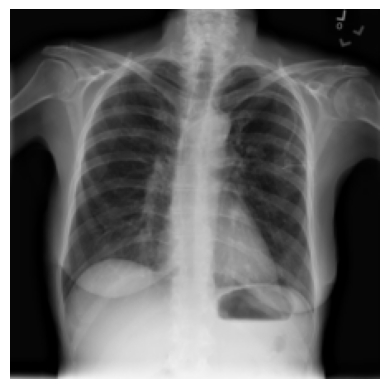

d:\Documentos\Datascience\machine_learning2\lung dissese\images/00000013_004.png


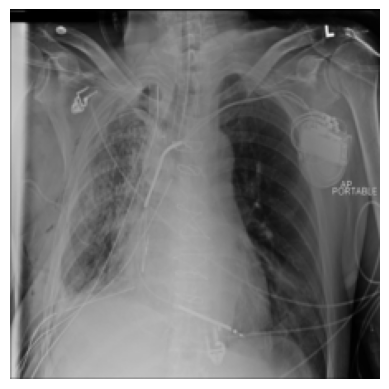

d:\Documentos\Datascience\machine_learning2\lung dissese\images/00000003_003.png


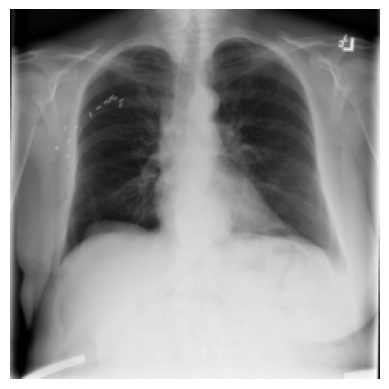

d:\Documentos\Datascience\machine_learning2\lung dissese\images/00000005_007.png


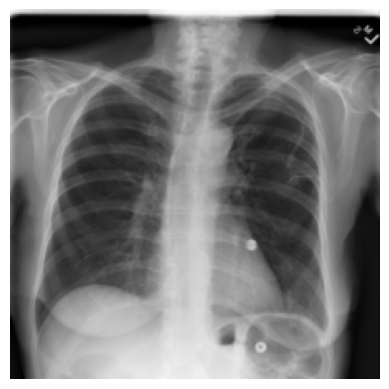

d:\Documentos\Datascience\machine_learning2\lung dissese\images/00000004_000.png


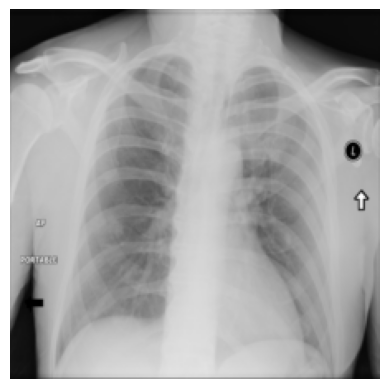

In [54]:
def visualize_photos(directory):
  random_photos = np.random.randint(0, len(directory), size = 5)
  for file in random_photos:
    image_path = directory + '/' + os.listdir(directory)[file]
    print(image_path)
    image = Image.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
    ])
    image = transform(image)

    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Visualize random photos
visualize_photos(images)

# Data Augmentation

List to possible transformations to make for data augmentation in [this list](https://pytorch.org/vision/main/transforms.html#geometry)

d:\Documentos\Datascience\machine_learning2\lung dissese\images/00000005_004.png


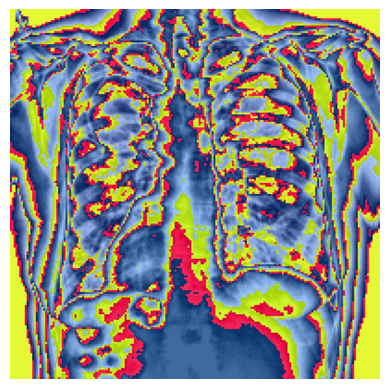

d:\Documentos\Datascience\machine_learning2\lung dissese\images/00000003_003.png


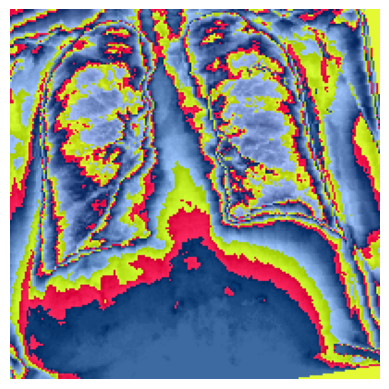

d:\Documentos\Datascience\machine_learning2\lung dissese\images/00000008_001.png


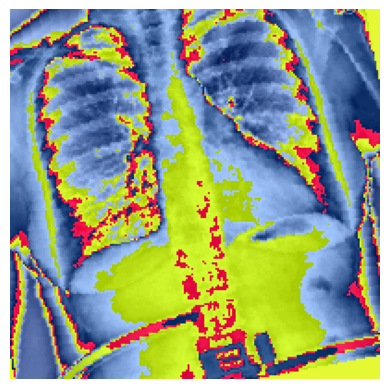

d:\Documentos\Datascience\machine_learning2\lung dissese\images/00000013_019.png


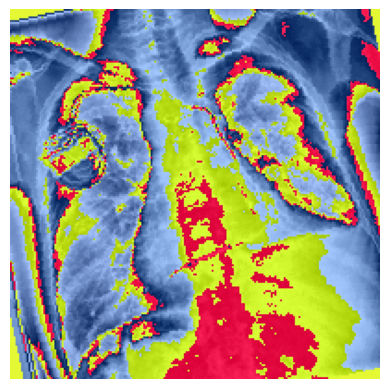

d:\Documentos\Datascience\machine_learning2\lung dissese\images/00000001_001.png


Exception ignored in: <function _ConnectionBase.__del__ at 0x000001CA065FAA70>
Traceback (most recent call last):
  File "d:\Documentos\Datascience\machine_learning2\lung dissese\lung\lib\multiprocessing\connection.py", line 132, in __del__
    self._close()
  File "d:\Documentos\Datascience\machine_learning2\lung dissese\lung\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] Controlador no válido


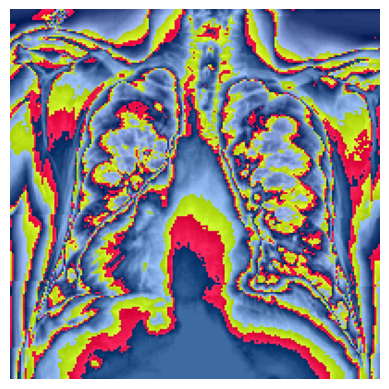

In [55]:
def visualize_photos_with_transforms(directory):
  random_photos = np.random.randint(0, len(directory), size = 5)
  for file in random_photos:
    image_path = directory + '/' + os.listdir(directory)[file]
    print(image_path)
    image = Image.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(30),      # Rotate the image by up to 30 degrees
        transforms.RandomCrop(200),         # Randomly crop the image to 224x224
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ColorJitter(brightness=0.2, hue=0.2, saturation=0.2),           # Randomly change brightness, contrast, saturation, and hue
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
    ])
    tensor_img = transform(image)

    to_pil = transforms.ToPILImage()
    image = to_pil(tensor_img)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Visualize the Data
visualize_photos_with_transforms(images)

# Convolutional Neural Network Setup

In [56]:
n_epochs = 3
batch_size = 64
learning_rate = 0.001
dropout_rate = 0.1

## Dataset & Dataloader

Now we add the condition for the cases, and retrieve the images in a list

In [57]:
# Testing code lines

# trial1 = []
# for f in listdir(images):
#   trial1.append(f)
# trial1
# train_disease['id']
# trial1 = [join(images, f) for f in listdir(images) if isfile(join(images, f)) and any(train['id'] == f.strip("'"))]
# trial1[0]
trial1 = train.iloc[0,0]
trial2 = train.iloc[0, [i for i in range(train.shape[1]) if i not in [0, 21]]]
labels = torch.tensor(trial2)
print(images+'/'+trial1)

# image_file = relevant_row['id'].values()

d:\Documentos\Datascience\machine_learning2\lung dissese\images/00000001_000.png


In [58]:
class Affections(Dataset):
    def __init__(self, img_dir, dataframe, transform=None):
        self.X = img_dir

        self.y = dataframe

        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_id = self.y.iloc[idx,0]
        relevant_row = self.y.iloc[idx, [i for i in range(self.y.shape[1]) if i not in [0, 21]]]
        labels = torch.tensor(relevant_row)

        image_path = self.X+'/'+img_id
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, labels

In [59]:
transform = transforms.Compose([
    transforms.RandomRotation(5),      # Rotate the image by up to 10 degrees
    transforms.CenterCrop(790),         # Randomly crop the image to 400x400
    transforms.ColorJitter(brightness=0.2, hue=0.2, saturation=0.2),           # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

In [60]:
torch.manual_seed(0)

In [61]:
dataset_train = Affections(images, train, transform=None)
dataset_test = Affections(images, test, transform=None)

train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=30)
test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=True, num_workers=30)

Sanity check to make sure the dataset is returning sensible photos with the correct labels

In [62]:
dataset_train[0]

(<PIL.Image.Image image mode=RGB size=1024x1024>,
 tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [64]:
print(dataset_train[0][0].to(device).shape)

AttributeError: 'Image' object has no attribute 'to'

# Training the model

## Implementing a Convolutional Neural Network

In [1]:
class AffectionsCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(AffectionsCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.conv1_drop = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(10, 30, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(dropout_rate)
        self.conv3 = nn.Conv2d(30, 20, kernel_size=3)
        self.conv3_drop = nn.Dropout2d(dropout_rate)

        self.fc_input_size = self.calculate_fc_input_size((3, 790, 790))

        self.fc1 = nn.Linear(self.fc_input_size, 5000)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(5000, 1000)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(1000, 20)

    def calculate_fc_input_size(self, input_size):
        with torch.no_grad():
            x = torch.zeros(1, *input_size)
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            x = self.conv1_drop(x)
            x = F.relu(F.max_pool2d(self.conv2(x), 2))
            x = self.conv2_drop(x)
            x = F.relu(F.max_pool2d(self.conv3(x), 2))
            x = self.conv3_drop(x)

            return x.view(1, -1).size(1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.conv1_drop(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.conv2_drop(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.conv3_drop(x)

        x = x.view(-1, self.fc_input_size)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        return torch.sigmoid(self.fc3(x))

NameError: name 'nn' is not defined

In [1]:
model = AffectionsCNN().to(device, non_blocking=True)
print(model)

# Assuming dataset_train is your training dataset
# Adjust this line based on your actual dataset structure
sample_data = dataset_train[0][0].to(device, non_blocking=True)
sample_data = sample_data.interpolate(sample_data, size=(500, 500))

# Forward pass
output = model(sample_data)

# Sanity check
assert output.shape == (1, 20)


########################
## Visualizar el modelo
# import torch
# from torchviz import make_dot

# # Define the model
# model = AffectionsCNN()

# # Create a dummy input tensor
# dummy_input = torch.randn(1, 3, 790, 790)

# # Forward pass to generate a computational graph
# output = model(dummy_input)

# # Visualize the computational graph
# graph = make_dot(output, params=dict(model.named_parameters()))
# graph.render('AffectionsCNN', format='png', cleanup=True)

NameError: name 'AffectionsCNN' is not defined

In [ ]:
loss_function = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# resnet_model = torch.load(/content/mode.pth)
# model.predict(image)

## Hyperparameters Setting

In [ ]:
n_epochs = 3
batch_size = 64
learning_rate = 0.001
dropout_rate = 0.1

## Optimization Loop

In [ ]:
# Note: network.train() puts the network into "nondeterministic mode".
def train_loop(network, optimizer, epoch, log_interval = 3):
  network.train()
  loss_logs = list()

  for batch_idx, (data, target) in enumerate(train_loader):
    num_batches = len(train_loader)
    size = len(train_loader.dataset)

    # To account for GPU
    data, target = data.to(device), target.to(device)

    # TODO: Fill in the code below for training
    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    output = network(data)
    #breakpoint()

    # Compute loss - Use the negative log likelihood loss function
    loss = loss_function(output, target)
    #breakpoint()

    # Perform backpropagation - gradient update
    loss.backward()

    # Perform optimization
    optimizer.step()

    # print an update
    if batch_idx % log_interval == 0:
      examples_shown = batch_idx * len(data)
      total_examples = len(train_loader.dataset)
      fraction_shown = round(examples_shown / total_examples * 100., 2)
      rounded_loss = round(loss.item(), 4)
      print(f'Train Epoch {epoch} Progress: {fraction_shown}%\tLoss: {rounded_loss}')

      examples_so_far = batch_idx*batch_size + epoch*len(train_loader.dataset)
      loss_logs.append((examples_so_far, loss.item()))
  return loss_logs

train_loop(model, optimizer, n_epochs, log_interval = 3)

RuntimeError: DataLoader worker (pid(s) 29432, 24596, 18500, 4304, 23812, 24508, 25432, 31856, 22776, 29980, 26460, 10140, 32984, 25448, 28588, 18808, 14460, 33400, 29616, 29460) exited unexpectedly

In [ ]:
from tqdm import tqdm

def test(network):
    network.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader):
            # To account for GPU
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += loss_function(output, target).item()

            # Threshold predictions for binary classification
            pred = output >= 0.5
            correct += pred.eq(target.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    accuracy = round(100. * correct.item() / len(test_loader.dataset), 2)
    print(f'\nTest set: Avg loss {round(test_loss, 4)}, Accuracy {accuracy}%\n')
    return test_loss, accuracy


In [ ]:
test_accuracies, test_losses, train_losses = list(), list(), list()
total_examples_seen = 0

for epoch in range(n_epochs):
  test_loss, test_accuracy = test(model)
  train_loss_logs = train(model, optimizer, epoch)
  # logging
  test_accuracies.append((epoch, test_accuracy))
  test_losses.append((total_examples_seen, test_loss))
  train_losses.extend((train_loss_logs))
  total_examples_seen = train_loss_logs[-1][0]

test_loss, test_accuracy = test(model)
test_accuracies.append((n_epochs, test_accuracy))
test_losses.append((total_examples_seen, test_loss))

NameError: name 'n_epochs' is not defined

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_results(test_accuracies, test_losses, train_losses):
  # plot training losses and test losses together
  training_x_values = [x[0] for x in train_losses]
  training_losses = [x[1] for x in train_losses]
  plt.plot(training_x_values, training_losses)
  test_x_values = [x[0]  for x in test_losses]
  test_loss_values = [x[1] for x in test_losses]
  plt.plot(test_x_values, test_loss_values, linestyle='--', marker='o', color='r')
  # plt.scatter(test_x_values, test_loss_values, color='r')
  plt.ylabel('Binary Cross Entropy Train loss')
  plt.xlabel('Examples seen')
  plt.show()

  # Next, plot test accuracy over time
  test_accuracy_x_values = [x[0] for x in test_accuracies]
  test_accuracy_values = [x[1] for x in test_accuracies]
  plt.plot(test_accuracy_x_values, test_accuracy_values, color='g', marker='o')
  plt.ylabel('Test Accuracy')
  plt.xlabel('Epochs')

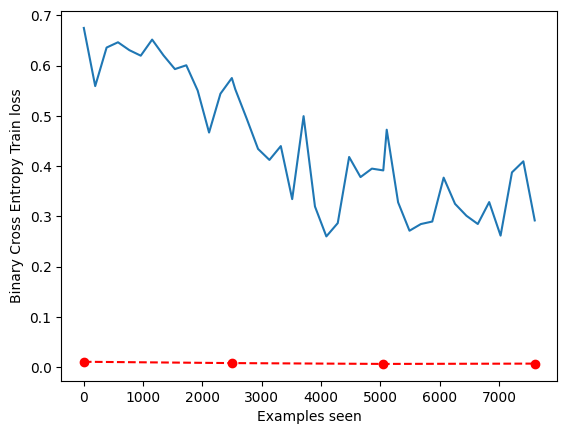

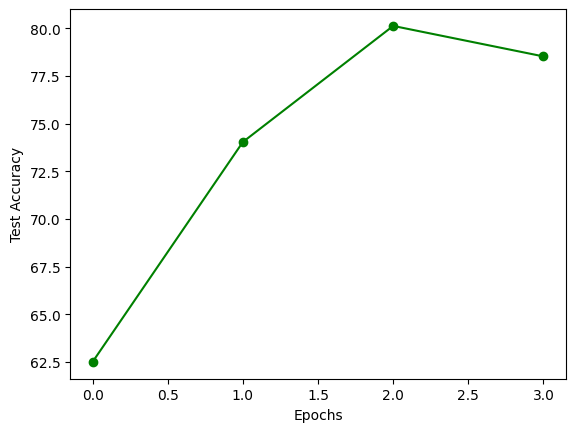

In [ ]:
plot_results(test_accuracies, test_losses, train_losses)

Did your model train well? If not you may want to go back up and revisit & tweak your hyperparameters. The instructors were able to get test accuracy of ~82%. As a baseline please try to get your test accuracy above 62.5%. & please share what works and what doesn't work with your fellow classmates - we're all curious to know what works and what doesn't!

## **NOTE:** Training neural networks often involves some element of luck. Sometimes even well chosen hyperparameters won't train well the first time. You may find it useful to rerun a couple of different times...

Sanity check on model preditions

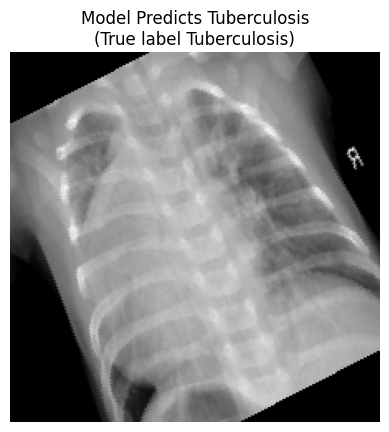

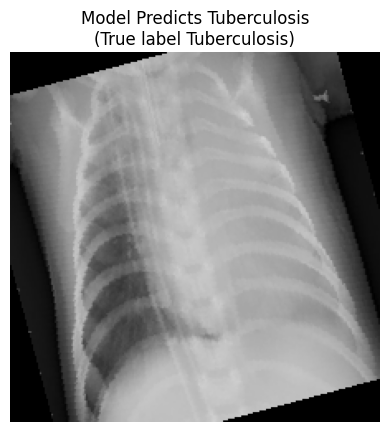

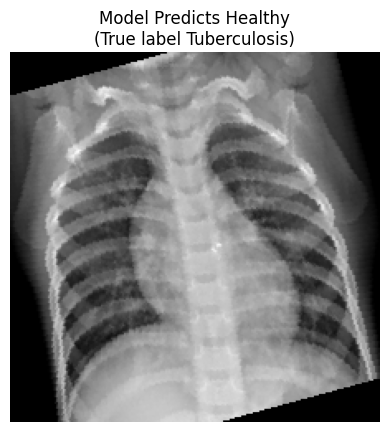

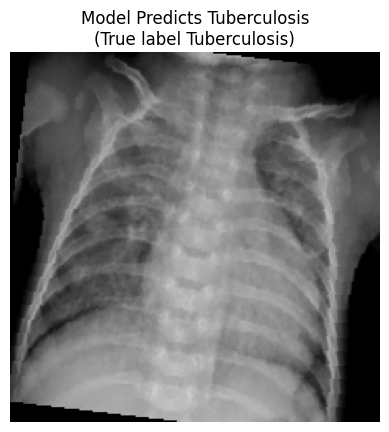

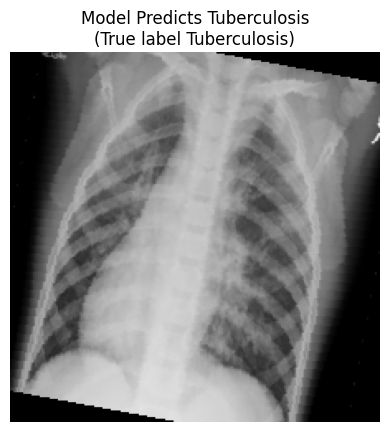

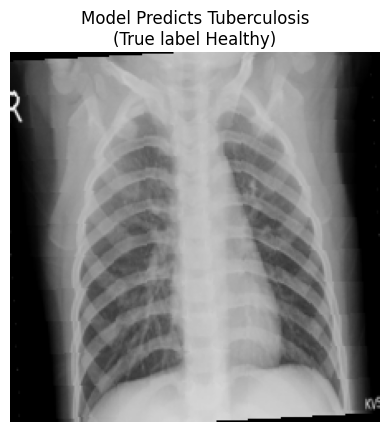

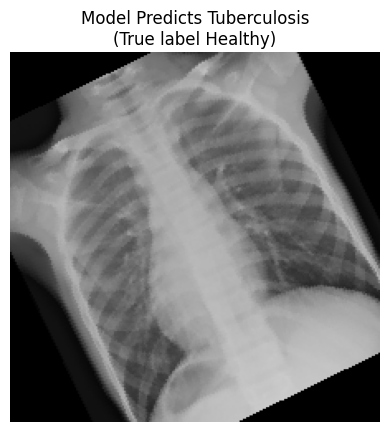

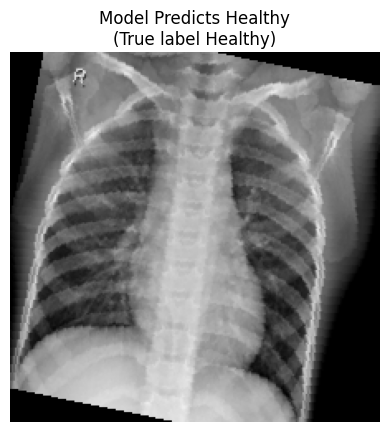

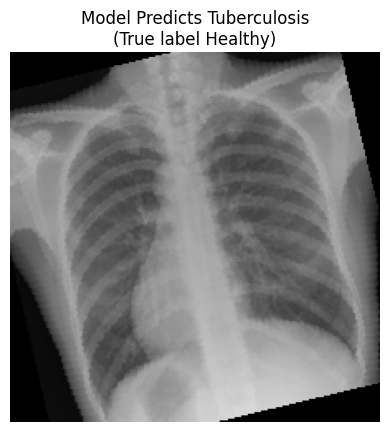

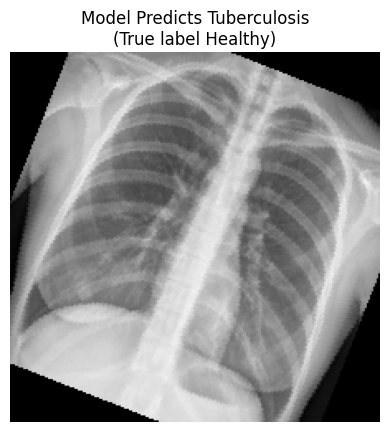

In [ ]:
def visualize_prediction(datapoint, model):
  to_pil = transforms.ToPILImage()
  image = to_pil(datapoint[0])
  plt.imshow(image)
  title = 'Model Predicts Tuberculosis' if model(datapoint[0]) > 0.5 else 'Model Predicts Healthy'
  subtitle = '(True label Tuberculosis)' if datapoint[1] else '(True label Healthy)'
  plt.title(title + '\n' + subtitle)
  plt.axis('off')
  plt.show()


visualize_prediction(dataset_test[0], model)
visualize_prediction(dataset_test[1], model)
visualize_prediction(dataset_test[2], model)
visualize_prediction(dataset_test[3], model)
visualize_prediction(dataset_test[4], model)
visualize_prediction(dataset_test[-1], model)
visualize_prediction(dataset_test[-2], model)
visualize_prediction(dataset_test[-3], model)
visualize_prediction(dataset_test[-4], model)
visualize_prediction(dataset_test[-5], model)

# MNIST Unsupervised

In this exercise, we are going to come back to exploring image data using [MNIST](http://yann.lecun.com/exdb/mnist/) for some **unsupervised** methods. As you all are familiar with, MNIST is a data set of handwritten digits. Below, we have plotted 5 random examples from this data set, and we have also loaded a set of MNIST data into a variable called `data`.





100%|██████████| 9912422/9912422 [00:00<00:00, 114184794.24it/s]


Extracting sample_data/MNIST/raw/train-images-idx3-ubyte.gz to sample_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 104157948.26it/s]


Extracting sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to sample_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33564141.70it/s]


Extracting sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to sample_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21772032.88it/s]


Extracting sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to sample_data/MNIST/raw

Showing 5 random images:


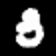

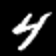

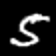

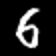

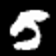


Shape of our MNIST Data Matrix: (60000, 28, 28)


In [ ]:
#@title
import torch
import torchvision

data_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('sample_data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=True)

#@title
from PIL import Image
import numpy as np
from io import BytesIO
import IPython.display

def show_random_image():
  dataset = np.array(data_loader.dataset.data)
  num_images = dataset.shape[0]
  image_idx = np.random.randint(low=0, high=num_images)
  pil_image = Image.fromarray(np.array(data_loader.dataset.data[image_idx]))
  height, width = pil_image.size
  pil_image = pil_image.resize((height*2, width*2))
  f = BytesIO()
  pil_image.save(f, 'png')
  IPython.display.display(IPython.display.Image(data=f.getvalue()))


#@title
num_images_to_show = 5
print(f'Showing {num_images_to_show} random images:')
for display_idx in range(num_images_to_show):
  show_random_image()
  print()

data = data_loader.dataset.data
data = np.array(data)
print('Shape of our MNIST Data Matrix: ' + str(data.shape))

## Data Exploration

### Image Visualization

We can begin with some pre-written functions to visualize some of the images in our data set!

In [ ]:
def plot_image(data):
  # Input = Index of the Image You Want to
  plt.figure()
  plt.imshow(data, cmap='gray')
  plt.title('Example Image from MNIST')
  plt.xlabel('Pixel')
  plt.ylabel('Pixel')
  plt.show()

In [ ]:
print('Shape of our MNIST Data Matrix: ' + str(data.shape))

Shape of our MNIST Data Matrix: (60000, 28, 28)


In [ ]:
print('Looking at a chunk of the Matrix of One Image: \n' + str(data[10, 10:20, 10:20]))

Looking at a chunk of the Matrix of One Image: 
[[  0   0   0  24 209 254 254 254 171   0]
 [  0   0  91 137 253 254 254 254 112   0]
 [ 40 214 250 254 254 254 254 254  34   0]
 [ 81 247 254 254 254 254 254 254 146   0]
 [  0 110 246 254 254 254 254 254 171   0]
 [  0   0  73  89  89  93 240 254 171   0]
 [  0   0   0   0   0   1 128 254 219  31]
 [  0   0   0   0   0   7 254 254 214  28]
 [  0   0   0   0   0 138 254 254 116   0]
 [  0   0   0   0  25 240 254 254  34   0]]


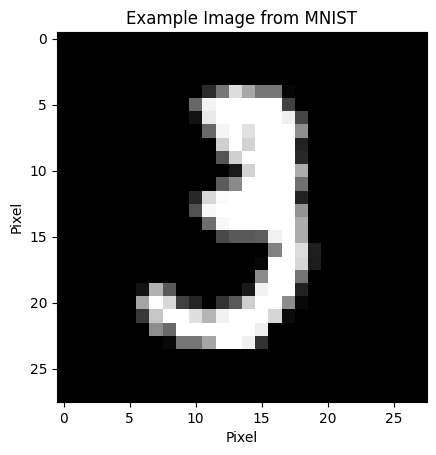

In [ ]:
image_to_plot = data[10, :, :]
plot_image(image_to_plot)

## Unsupervised Exploration of Handwritten Digits

We gave you the data first, in a way that makes sense: as a matrix in the same shape as the shape of the image.

However, working with these features w/ unsupervised methods, we can also do something **unintuitive**! We can unravel the matrix into one long vector of values

In [ ]:
train = pd.read_csv('/content/sample_data/mnist_train_small.csv', header = None)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test = pd.read_csv('/content/sample_data/mnist_test.csv', header = None)
test.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test = pd.read_csv('/content/sample_data/mnist_test.csv', header = None)
test.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 0, 'Unwrapped Pixel Location')

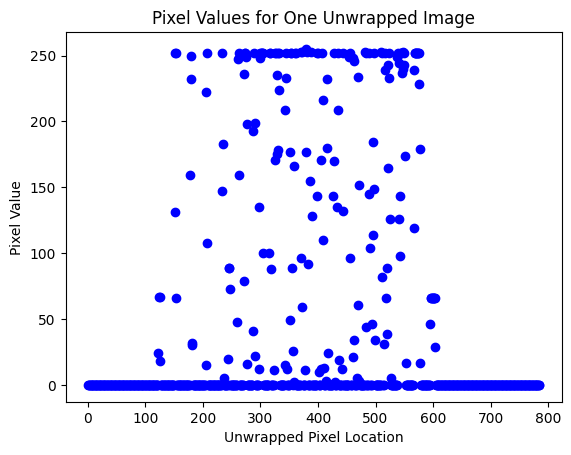

In [ ]:
plt.plot(train.loc[0, 1:], 'bo')
plt.title('Pixel Values for One Unwrapped Image');
plt.ylabel('Pixel Value')
plt.xlabel('Unwrapped Pixel Location')

# Massaging the data into familiar X_train, y_train, X_test, y_test splits

Though we are separating the data into training and testing splits, Note we are not actually training on the data! Just running the unsupervised PCA method upon it

In [ ]:
X_train = train.loc[:, 1:]
y_train = train.loc[:, 0]
print(X_train.shape)
print(y_train.shape)

(20000, 784)
(20000,)


In [ ]:
X_test = test.loc[:, 1:]
y_test = test.loc[:, 0]
print(X_test.shape)
print(y_test.shape)

(10000, 784)
(10000,)


# Exercise: Fit a two component PCA upon the X_train dataset of MNIST pictures

Principle component analysis (PCA) is an unsupervised technique that takes unlabelled data and reduces its dimension. In our case we have images of handwritten digits, pretending we can't read and don't know the correct label for these images we can use PCA to reduce the dimension of the dataset (from 784 down to 2 dimensions). Then plot the 2 dimensions and either manually or algorithmically cluster the handwritten images into their original classes.

Tasks:
- Fit PCA() with n_components = 2 on X_train... Refer to https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [ ]:
# Fit PCA to Pixels
X_pcaed = None


pca = PCA(n_components = 2)
X_pcaed = pca.fit_transform(X_train)
print(X_train.shape)
print(X_pcaed.shape)

(20000, 784)
(20000, 2)


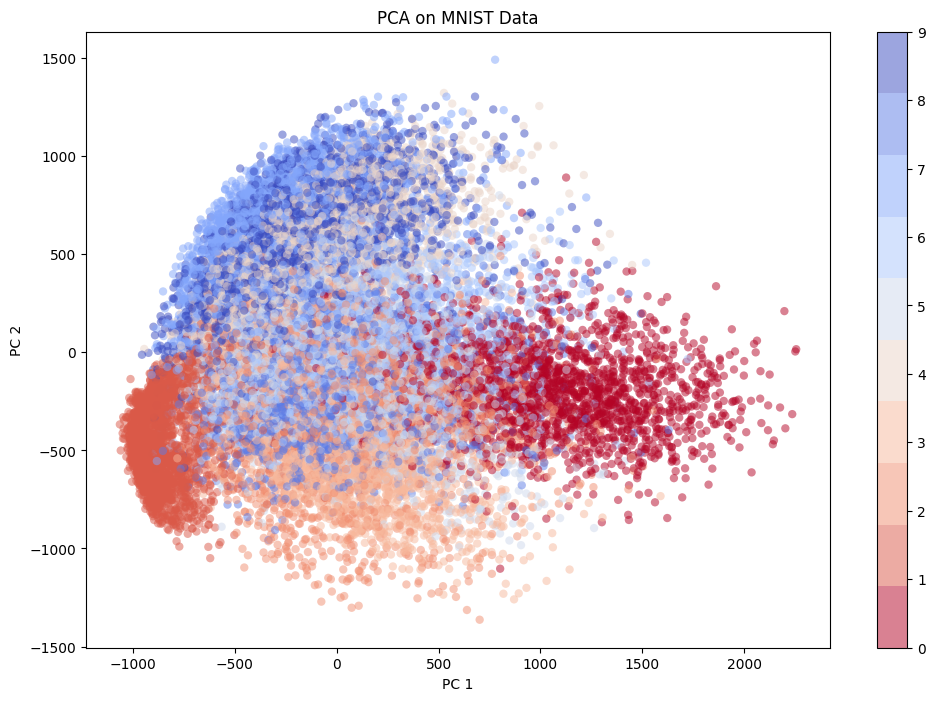

In [ ]:
# Visualize PCA
plt_pic = plt.figure(figsize = (12, 8))
plt.scatter(X_pcaed[:, 0], X_pcaed[:, 1],
            c = y_train, edgecolor = "none", alpha = 0.5,
            cmap = plt.cm.get_cmap("coolwarm_r", 10))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title("PCA on MNIST Data")
plt.colorbar();

In [ ]:
# Fit PCA to Pixels
pca2 = PCA(n_components = 300)
X_train_pca2 = pca2.fit_transform(X_train)
X_test_pca2 = pca2.transform(X_test)
print(X_train_pca2.shape)
print(X_test_pca2.shape)

(20000, 300)
(10000, 300)


PCA can be tuned, the more components included the higher the variance explained until # components == # of original dimensions and all variance is explained.


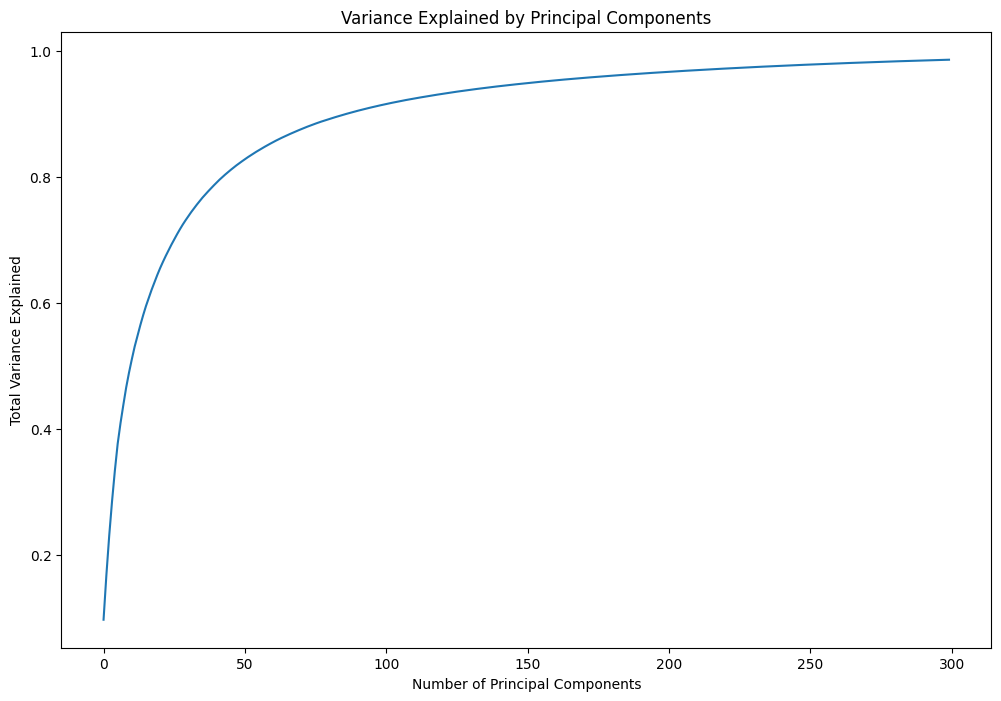

In [ ]:
# proportion of variance explained
plt_pic = plt.figure(figsize = (12, 8))
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Total Variance Explained')
plt.title("Variance Explained by Principal Components");